In [1]:
# no longer need to install here because it was installed in our base image
#install.packages("BiocManager")
#install.packages(c('BiocManager'), repos='https://cloud.r-project.org/');BiocManager::install('WGCNA')
library(WGCNA)

Loading required package: dynamicTreeCut

Loading required package: fastcluster


Attaching package: ‘fastcluster’


The following object is masked from ‘package:stats’:

    hclust





Attaching package: ‘WGCNA’


The following object is masked from ‘package:stats’:

    cor




In [2]:
#remove.packages("tidyverse") 
install.packages("tidyverse")


also installing the dependency ‘ragg’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [3]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [4]:
# read in the normalized expression
# expecting the output from DESeq2 where data are normalized
data <- readr::read_delim("/sbgenomics/project-files/test_data_GenePhenotypeFile.csv",  
                          delim = ",")

Rows: 9 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): gene_id
dbl (9): AHM_1, GB_1, AHM_2, GB_2, AHM_3, GB_3, AHM_4, AHM_5, GB_4

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
data[1:9,1:10]

gene_id,AHM_1,GB_1,AHM_2,GB_2,AHM_3,GB_3,AHM_4,AHM_5,GB_4
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
EEF1A1,583178.02,198114.5,174740.7,195864.6,208449.6,351522.1,240541.6,206245.0,181641.8
HLA-B,137277.82,195562.8,420754.0,189800.0,159606.3,221018.3,174418.7,211173.8,273057.2
MT-CO1,70944.48,330873.5,417645.0,262104.1,170003.1,259356.0,176001.8,335401.6,307714.7
ACTB,116769.00,218685.0,298491.0,191708.0,208556.0,187905.0,176015.0,201335.0,212572.0
B2M,241327.00,113145.0,79821.0,129504.0,76920.0,234909.0,114442.0,108754.0,69113.0
HLA-C,97104.82,152159.0,364501.0,149474.4,106488.8,176300.3,150068.1,174590.1,187500.5
HLA-A,118454.06,161938.2,227078.2,180870.7,115964.0,148752.1,101970.1,173667.3,146388.5
HLA-E,98642.52,161444.7,207360.0,165691.4,127941.8,138773.2,109481.0,149838.5,163524.0
MT-RNR2,81384.00,155722.0,156351.0,157627.0,70869.0,168792.0,80113.0,154166.0,138565.0


In [40]:
de_input = as.matrix(data[,-1])
row.names(de_input) = data$GeneId
de_input[1:9,1:9]

,AHM_1,GB_1,AHM_2,GB_2,AHM_3,GB_3,AHM_4,AHM_5,GB_4
EEF1A1,583178.02,198114.5,174740.7,195864.6,208449.6,351522.1,240541.6,206245.0,181641.8
HLA-B,137277.82,195562.8,420754.0,189800.0,159606.3,221018.3,174418.7,211173.8,273057.2
MT-CO1,70944.48,330873.5,417645.0,262104.1,170003.1,259356.0,176001.8,335401.6,307714.7
ACTB,116769.00,218685.0,298491.0,191708.0,208556.0,187905.0,176015.0,201335.0,212572.0
B2M,241327.00,113145.0,79821.0,129504.0,76920.0,234909.0,114442.0,108754.0,69113.0
HLA-C,97104.82,152159.0,364501.0,149474.4,106488.8,176300.3,150068.1,174590.1,187500.5
HLA-A,118454.06,161938.2,227078.2,180870.7,115964.0,148752.1,101970.1,173667.3,146388.5
HLA-E,98642.52,161444.7,207360.0,165691.4,127941.8,138773.2,109481.0,149838.5,163524.0
MT-RNR2,81384.00,155722.0,156351.0,157627.0,70869.0,168792.0,80113.0,154166.0,138565.0


In [42]:
meta_df <- data.frame( Sample = names(data[-1])) %>%
  mutate(
    Type = gsub("-.*","", Sample) %>% gsub("[.].*","", .)
  )
meta_df

Sample,Type
<chr>,<chr>
AHM_1,AHM_1
GB_1,GB_1
AHM_2,AHM_2
GB_2,GB_2
AHM_3,AHM_3
GB_3,GB_3
AHM_4,AHM_4
AHM_5,AHM_5
GB_4,GB_4


In [44]:
#the deseq normlization step is executed outside of here
# input_mat <- t(expr_normalized) 
input_mat<- t(de_input)
input_mat[1:9,1:9]

,EEF1A1,HLA-B,MT-CO1,ACTB,B2M,HLA-C,HLA-A,HLA-E,MT-RNR2
AHM_1,583178.0,137277.8,70944.48,116769,241327,97104.82,118454.1,98642.52,81384
GB_1,198114.5,195562.8,330873.50,218685,113145,152158.96,161938.2,161444.73,155722
AHM_2,174740.7,420754.0,417644.98,298491,79821,364501.00,227078.2,207360.00,156351
GB_2,195864.6,189800.0,262104.06,191708,129504,149474.44,180870.7,165691.44,157627
AHM_3,208449.6,159606.3,170003.11,208556,76920,106488.77,115964.0,127941.82,70869
GB_3,351522.1,221018.3,259355.96,187905,234909,176300.28,148752.1,138773.22,168792
AHM_4,240541.6,174418.7,176001.81,176015,114442,150068.14,101970.1,109481.00,80113
AHM_5,206245.0,211173.8,335401.58,201335,108754,174590.12,173667.3,149838.46,154166
GB_4,181641.8,273057.2,307714.71,212572,69113,187500.47,146388.5,163524.00,138565


In [45]:
names(data)[1] = "GeneId"
names(data)           # Look at the column names

[1] "GeneId" "AHM_1"  "GB_1"   "AHM_2"  "GB_2"   "AHM_3"  "GB_3"   "AHM_4" 
 [9] "AHM_5"  "GB_4"

In [46]:
input_mat[1:9,1:9]

,EEF1A1,HLA-B,MT-CO1,ACTB,B2M,HLA-C,HLA-A,HLA-E,MT-RNR2
AHM_1,583178.0,137277.8,70944.48,116769,241327,97104.82,118454.1,98642.52,81384
GB_1,198114.5,195562.8,330873.50,218685,113145,152158.96,161938.2,161444.73,155722
AHM_2,174740.7,420754.0,417644.98,298491,79821,364501.00,227078.2,207360.00,156351
GB_2,195864.6,189800.0,262104.06,191708,129504,149474.44,180870.7,165691.44,157627
AHM_3,208449.6,159606.3,170003.11,208556,76920,106488.77,115964.0,127941.82,70869
GB_3,351522.1,221018.3,259355.96,187905,234909,176300.28,148752.1,138773.22,168792
AHM_4,240541.6,174418.7,176001.81,176015,114442,150068.14,101970.1,109481.00,80113
AHM_5,206245.0,211173.8,335401.58,201335,108754,174590.12,173667.3,149838.46,154166
GB_4,181641.8,273057.2,307714.71,212572,69113,187500.47,146388.5,163524.00,138565


In [47]:
allowWGCNAThreads()          # allow multi-threading (optional)
#> Allowing multi-threading with up to 4 threads.

Allowing multi-threading with up to 8 threads.


In [48]:
# Choose a set of soft-thresholding powers
powers = c(c(1:10), seq(from = 12, to = 20, by = 2))

In [49]:
# Call the network topology analysis function
sft = pickSoftThreshold(
  input_mat,             # <= Input data
  #blockSize = 30,
  powerVector = powers,
  verbose = 5
  )

pickSoftThreshold: will use block size 9.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 9 of 9
   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1 0.014000 -6.840        -0.0885   5.350     5.610  6.340
2      2 0.004810  2.330         0.1900   3.970     4.290  5.170
3      3 0.000349  0.484         0.2650   3.100     3.420  4.300
4      4 0.021300  3.530         0.4210   2.510     2.840  3.630
5      5 0.026100  3.810         0.4420   2.070     2.430  3.110
6      6 0.014500  2.610         0.4470   1.740     2.120  2.690
7      7 0.006910  1.690         0.4400   1.480     1.830  2.350
8      8 0.025600  2.780         0.3930   1.280     1.550  2.060
9      9 0.174000  8.070         0.4360   1.110     1.310  1.820
10    10 0.165000  7.550         0.3890   0.967     1.120  1.610
11    12 0.060200  4.230         0.2720   0.754     0.815  1.280
12    14 0.001450  0.612        -0.2130   0.602     0.602  1.070
13    16 

In [50]:
col_sel = names(data)[-1]     # Get all but first column name
col_sel

[1] "AHM_1" "GB_1"  "AHM_2" "GB_2"  "AHM_3" "GB_3"  "AHM_4" "AHM_5" "GB_4"

Optional step ---  order the groups in the plot.
mdata$group = factor(mdata$group,
                    levels = c("B", "B_L1", ....))  #<= fill the rest of this in

In [51]:
mdata <- data %>%
  tidyr::pivot_longer(
    .,                        # The dot is the the input data, magrittr tutorial
    col = all_of(col_sel)
    ) %>%  
  mutate(
    group = gsub("-.*","", name) %>% gsub("[.].*","", .)   # Get the shorter treatment names
  )


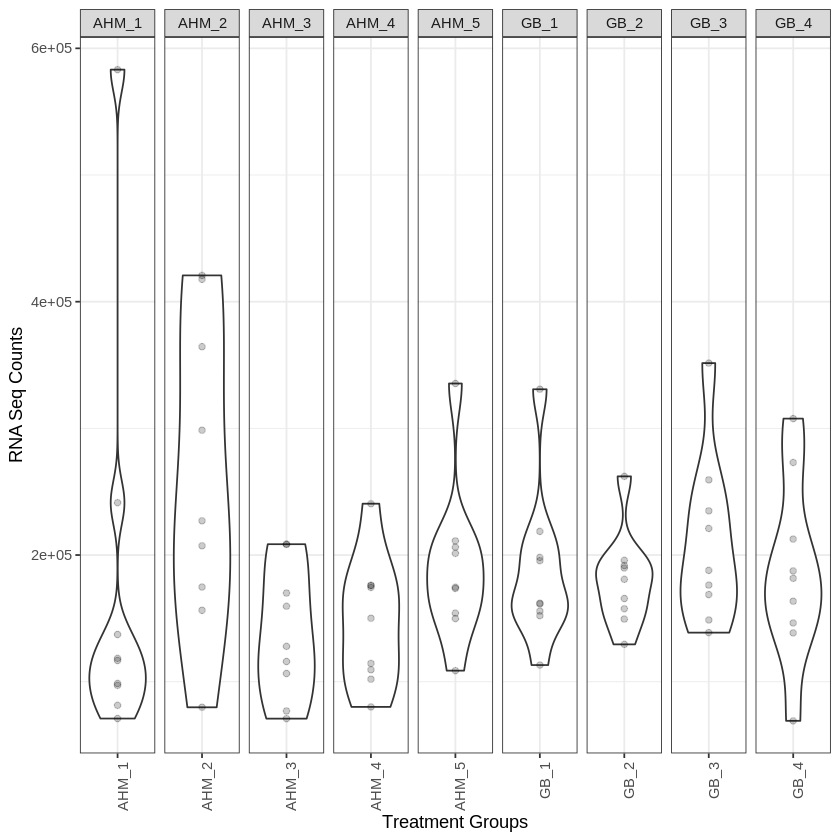

In [52]:
# ==== Plot groups (Sample Groups vs RNA Seq Counts) to identify outliers
(
 p <- mdata %>%
    ggplot(., aes(x = name, y = value)) +             # x = treatment, y = RNA Seq count
    geom_violin() +                                   # violin plot, show distribution
    geom_point(alpha = 0.2) +                         # scatter plot
    theme_bw() +
    theme(
      axis.text.x = element_text(angle = 90)          # Rotate treatment text
    ) +
    labs(x = "Treatment Groups", y = "RNA Seq Counts") +
    facet_grid(cols = vars(group), drop = TRUE, scales = "free_x")      # Facet by hour
)

In [53]:
par(mfrow = c(1,2));
cex1 = 0.9;

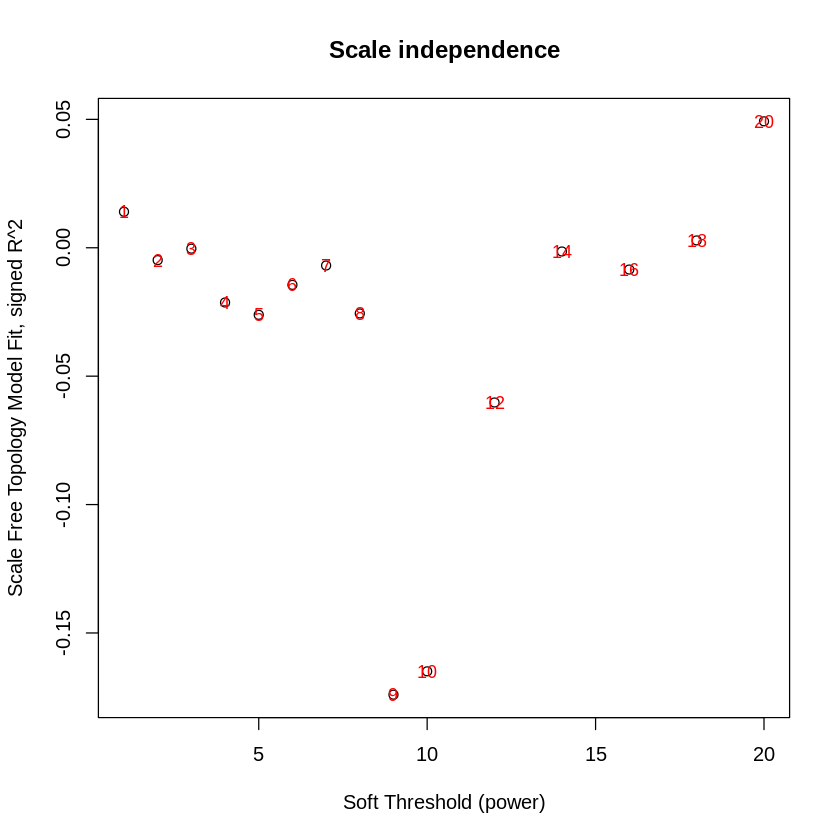

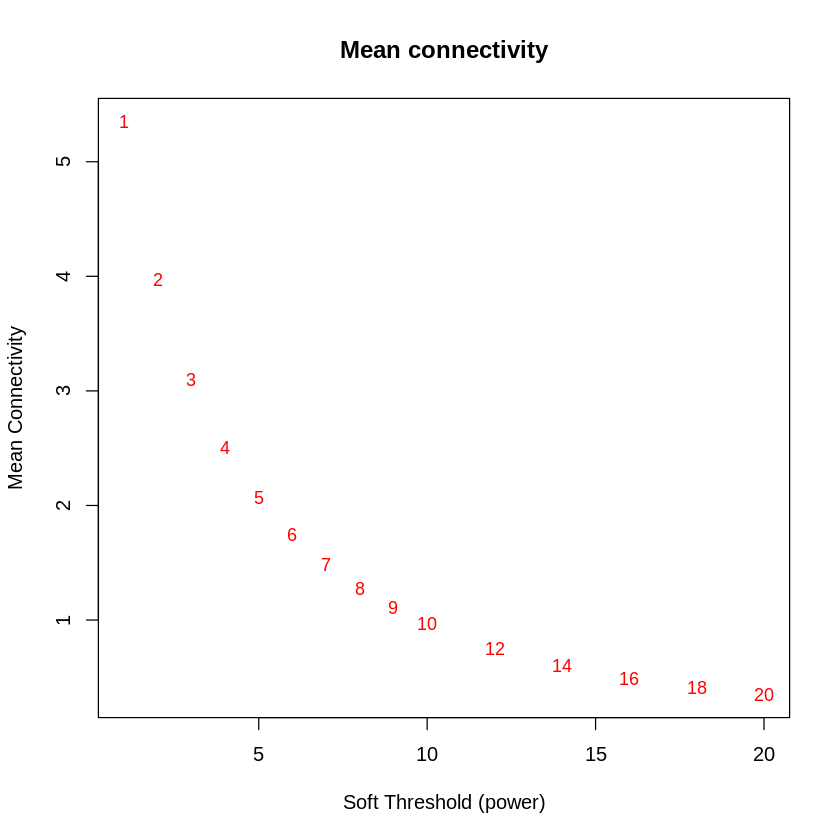

In [54]:
plot(sft$fitIndices[, 1],
     -sign(sft$fitIndices[, 3]) * sft$fitIndices[, 2],
     xlab = "Soft Threshold (power)",
     ylab = "Scale Free Topology Model Fit, signed R^2",
     main = paste("Scale independence")
)
text(sft$fitIndices[, 1],
     -sign(sft$fitIndices[, 3]) * sft$fitIndices[, 2],
     labels = powers, cex = cex1, col = "red"
)
abline(h = 0.90, col = "red")
plot(sft$fitIndices[, 1],
     sft$fitIndices[, 5],
     xlab = "Soft Threshold (power)",
     ylab = "Mean Connectivity",
     type = "n",
     main = paste("Mean connectivity")
)
text(sft$fitIndices[, 1],
     sft$fitIndices[, 5],
     labels = powers,
     cex = cex1, col = "red")

    picked_power = 9
temp_cor <- cor       
cor <- WGCNA::cor         
# Force it to use WGCNA cor function (fix a namespace conflict issue)
# <= input here

In [55]:
typeof(input_mat)


[1] "double"

In [56]:
input_mat

,EEF1A1,HLA-B,MT-CO1,ACTB,B2M,HLA-C,HLA-A,HLA-E,MT-RNR2
AHM_1,583178.0,137277.8,70944.48,116769,241327,97104.82,118454.1,98642.52,81384
GB_1,198114.5,195562.8,330873.50,218685,113145,152158.96,161938.2,161444.73,155722
AHM_2,174740.7,420754.0,417644.98,298491,79821,364501.00,227078.2,207360.00,156351
GB_2,195864.6,189800.0,262104.06,191708,129504,149474.44,180870.7,165691.44,157627
AHM_3,208449.6,159606.3,170003.11,208556,76920,106488.77,115964.0,127941.82,70869
GB_3,351522.1,221018.3,259355.96,187905,234909,176300.28,148752.1,138773.22,168792
AHM_4,240541.6,174418.7,176001.81,176015,114442,150068.14,101970.1,109481.00,80113
AHM_5,206245.0,211173.8,335401.58,201335,108754,174590.12,173667.3,149838.46,154166
GB_4,181641.8,273057.2,307714.71,212572,69113,187500.47,146388.5,163524.00,138565


In [57]:
netwk <- blockwiseModules(input_mat,               
    # == Adjacency Function ==
    power = picked_power,
    # <= power here
    networkType = "signed",
    # == Tree and Block Options ==
    deepSplit = 2,
    pamRespectsDendro = F,
    # detectCutHeight = 0.75,
    minModuleSize = 30,
    maxBlockSize = 4000,

    # == Module Adjustments ==
    reassignThreshold = 0,
    mergeCutHeight = 0.25,

    # == TOM == Archive the run results in TOM file (saves time)
    saveTOMs = T,
    saveTOMFileBase = "ER",

    # == Output Options
    numericLabels = T,
    verbose = 3)
cor <- temp_cor     # Return cor function to original namespace

 Calculating module eigengenes block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
 ..Working on block 1 .
    TOM calculation: adjacency..
    ..will not use multithreading.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
   ..saving TOM for block 1 into file ER-block.1.RData
 ....clustering..
 ....detecting modules..
 No modules detected in block 1
 ..merging modules that are too close..
     mergeCloseModules: Merging modules whose distance is less than 0.25


Warning message in blockwiseModules(input_mat, power = picked_power, networkType = "signed", :
“blockwiseModules: mergeCloseModules failed with the following error message:
     Error in mergeCloseModules(datExpr, colors[gsg$goodGenes], cutHeight = mergeCutHeight,  : 
  Error in moduleEigengenes(expr = exprData[[set]]$data, colors = setColors,  : 
  Color levels are empty. Possible reason: the only color is grey and grey module is excluded from the calculation.

 
--> returning unmerged colors.
”


Warning message in pmin(objHeights[dendro$order][floor(positions)], objHeights[dendro$order][ceiling(positions)]):
“an argument will be fractionally recycled”


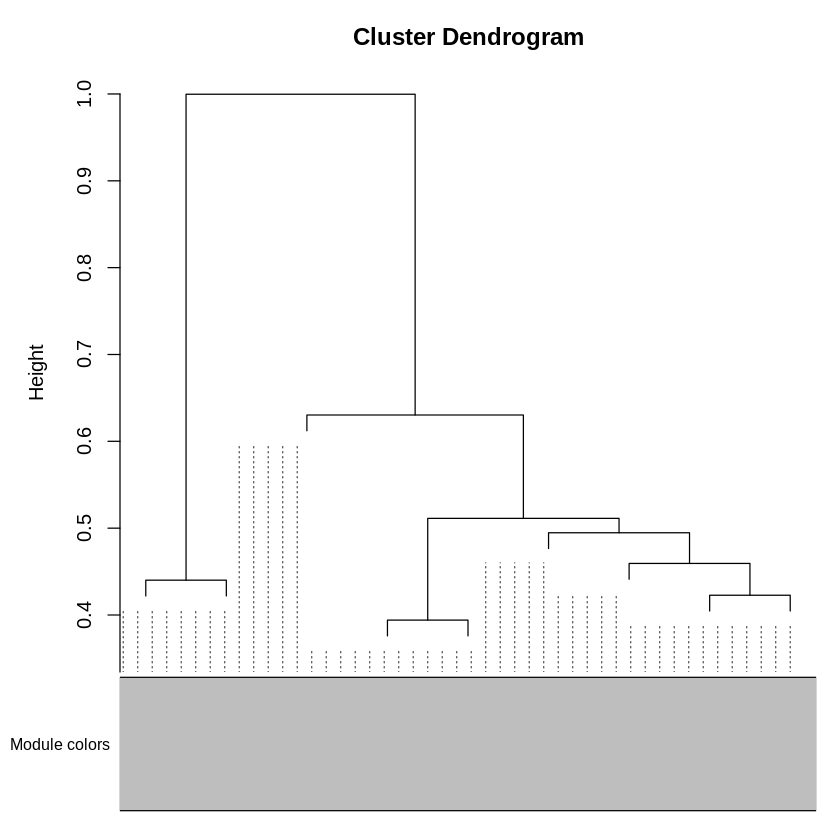

In [58]:
# Convert labels to colors for plotting
mergedColors = labels2colors(netwk$colors)
# Plot the dendrogram and the module colors underneath
plotDendroAndColors(
  netwk$dendrograms[[1]],
  mergedColors[netwk$blockGenes[[1]]],
  "Module colors",
  dendroLabels = FALSE,
  hang = 0.03,
  addGuide = TRUE,
  guideHang = 0.05 )

In [59]:
# netwk$colors[netwk$blockGenes[[1]]]
# table(netwk$colors)
module_df <- data.frame(
  gene_id = names(netwk$colors),
  colors = labels2colors(netwk$colors)
)

In [60]:
module_df[1:5,]
#>            gene_id    colors
#> 1 AC149818.2_FG001      blue
#> 2 AC149829.2_FG003      blue
#> 3 AC182617.3_FG001      blue
#> 4 AC186512.3_FG001 turquoise
#> 5 AC186512.3_FG007 turquoise

,gene_id,colors
,<chr>,<chr>
1,EEF1A1,grey
2,HLA-B,grey
3,MT-CO1,grey
4,ACTB,grey
5,B2M,grey


In [61]:
write_delim(module_df,
    file = "gene_modules.txt",
    delim = "\t")

In [62]:
# Get Module Eigengenes per cluster
MEs0 <- moduleEigengenes(input_mat, mergedColors)$eigengenes

In [63]:
# Reorder modules so similar modules are next to each other
MEs0 <- orderMEs(MEs0)
module_order = names(MEs0) %>% gsub("ME","", .)

In [64]:
# Add treatment names
MEs0$treatment = row.names(MEs0)

In [65]:
# tidy & plot data
mME = MEs0 %>%
  pivot_longer(-treatment) %>%
  mutate(
    name = gsub("ME", "", name),
    name = factor(name, levels = module_order)
  )

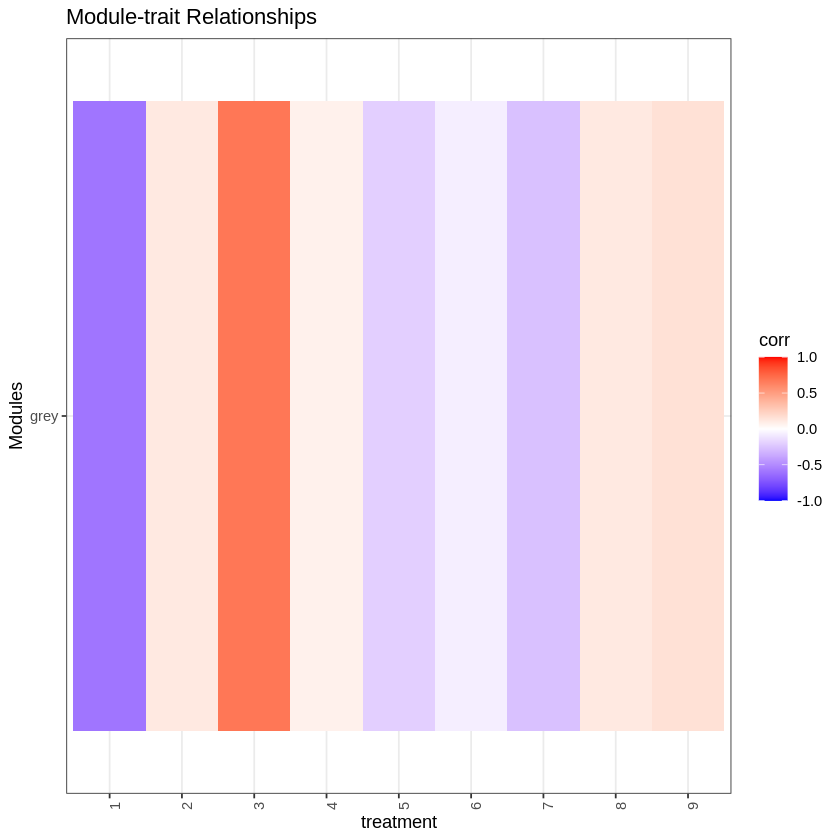

In [66]:
mME %>% ggplot(., aes(x=treatment, y=name, fill=value)) +
  geom_tile() +
  theme_bw() +
  scale_fill_gradient2(
    low = "blue",
    high = "red",
    mid = "white",
    midpoint = 0,
    limit = c(-1,1)) +
  theme(axis.text.x = element_text(angle=90)) +
  labs(title = "Module-trait Relationships", y = "Modules", fill="corr")